For DINO normal maybe should try feeding in the colors as B/R; don't want to replicate input on channels and then have the model get double--especiall as far as the dropout is concerned

In [2]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from data import CellImageDataset
from utils import get_intensity_metrics_sc, intensities_to_polar_pseudotime
import pandas as pd
from hpa_dino import HPA_DINO
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
FUCCI_DATA_DIR = Path('/data/ishang/FUCCI-dataset-well')
HPACC_DATA_DIR = Path('/data/ishang/HPA-CC-dataset')
CCNB1_DATA_DIR = Path('/data/ishang/CCNB1-dataset')

In [4]:
"""
FUCCI_CHAM: 512 crops, some intensity range that seems well calibrated (LHS)
FUCCI_TILE: 512 crops, some intensity range that is maybe a bit saturated (RHS, doesn't seem "saturated" as far as the DAPI/TUBL channel goes, maybe a bit of noise though for DAPI)
FUCCI_OVER: 512 crops, some intensity range that is a bit saturated (RHS)
CCNB1: 768 crops, some intensity range that seems well calibrated; it's mostly "chamber" and "tilescan" samples, which corresponds to 0 and 2
- Maybe it's worth checking differential accuracy there?
- This dataset also probably doesn't filter out as many bad cells because the 1250 filter is wrong, by the cell counts likely doesn't filter much
HPACC: 512 crops, likely has the most heterogeneity as such because it was constructed over time
"""
FUCCI_NORM = "well_spline_norm_512_crop_sharpness_1250"
FUCCI_NAME = "unnormalize_1250_sharp_512_crop_og_res"
FUCCI_CHAM_NAME = f"{FUCCI_NAME}_chamber"
FUCCI_TILE_NAME = f"{FUCCI_NAME}_tilescan"
FUCCI_OVER_NAME = f"{FUCCI_NAME}_overview"
HPACC_NAME = "512_min_max"
CCNB1_NAME = "full_res_768_crop_min_max_border_1250_sharp"

In [5]:
data_dirs = {
    "fucci": FUCCI_DATA_DIR,
    "fucci_norm": FUCCI_DATA_DIR,
    "fucci_cham": FUCCI_DATA_DIR,
    "fucci_tile": FUCCI_DATA_DIR,
    "fucci_over": FUCCI_DATA_DIR,
    "hpacc": HPACC_DATA_DIR,
    "ccnb1": CCNB1_DATA_DIR
}

dataset_fileext = {
    "fucci": FUCCI_NAME,
    "fucci_norm": FUCCI_NORM,
    "fucci_cham": FUCCI_CHAM_NAME,
    "fucci_tile": FUCCI_TILE_NAME,
    "fucci_over": FUCCI_OVER_NAME,
    "hpacc": HPACC_NAME,
    "ccnb1": CCNB1_NAME
}

In [6]:
fucci_datasets = [
    # "fucci",
    "fucci_cham",
    "fucci_tile",
    "fucci_over"
]


# DATASET PREP

In [20]:
FUCCI_index = pd.read_csv(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}.csv")
FUCCI_index.head()
str(FUCCI_index["image_path"][:2].values[0])

'/data/ishang/FUCCI-dataset-well/chamber--U02--V03/images_unnormalize_1250_sharp_512_crop_og_res.pt'

In [21]:
# check if "sample_name" contains the following microscope tag and make new dfs for each
FUCCI_index_chamber = FUCCI_index[FUCCI_index["sample_name"].str.contains("chamber")]
FUCCI_index_tilescan = FUCCI_index[FUCCI_index["sample_name"].str.contains("tilescan")]
FUCCI_index_overview = FUCCI_index[FUCCI_index["sample_name"].str.contains("overview")]
print(FUCCI_index_chamber.shape, FUCCI_index_tilescan.shape, FUCCI_index_overview.shape, FUCCI_index.shape)

(94, 4) (35, 4) (13, 4) (142, 4)


In [22]:
# save each as a new index with the corresponding suffix
FUCCI_index_chamber.to_csv(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}_chamber.csv", index=False)
FUCCI_index_tilescan.to_csv(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}_tilescan.csv", index=False)
FUCCI_index_overview.to_csv(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}_overview.csv", index=False)

In [23]:
dataset_indices = {
    "fucci": FUCCI_index,
    "fucci_norm": pd.read_csv(FUCCI_DATA_DIR / f"index_{FUCCI_NORM}.csv"),
    "fucci_cham": FUCCI_index_chamber,
    "fucci_tile": FUCCI_index_tilescan,
    "fucci_over": FUCCI_index_overview,
    "hpacc": pd.read_csv(HPACC_DATA_DIR / f"index_{HPACC_NAME}.csv"),
    "ccnb1": pd.read_csv(CCNB1_DATA_DIR / f"index_{CCNB1_NAME}.csv")
}

# LOAD DATA

In [24]:
data_dirs = {
    # "fucci": FUCCI_DATA_DIR,
    # "fucci_norm": FUCCI_DATA_DIR,
    # "fucci_cham": FUCCI_DATA_DIR,
    # "fucci_tile": FUCCI_DATA_DIR,
    # "fucci_over": FUCCI_DATA_DIR,
    "hpacc": HPACC_DATA_DIR,
    # "ccnb1": CCNB1_DATA_DIR
}

In [25]:
# datasets = {
#     "fucci_cham": CellImageDataset(FUCCI_DATA_DIR / f"index_{FUCCI_CHAM_NAME}.csv", channel_colors=["blue", "red"], channels=[0, 1], batch_size=1),
#     "fucci_tile": CellImageDataset(FUCCI_DATA_DIR / f"index_{FUCCI_TILE_NAME}.csv", channel_colors=["blue", "red"], channels=[0, 1], batch_size=1),
#     "fucci_over": CellImageDataset(FUCCI_DATA_DIR / f"index_{FUCCI_OVER_NAME}.csv", channel_colors=["blue", "red"], channels=[0, 1], batch_size=1),
#     "hpacc": CellImageDataset(HPACC_DATA_DIR / f"index_{HPACC_NAME}.csv", channel_colors=["blue", "red"], channels=[0, 1], batch_size=1),
#     "ccnb1": CellImageDataset(CCNB1_DATA_DIR / f"index_{CCNB1_NAME}.csv", channel_colors=["blue", "red"], channels=[0, 1], batch_size=1),
# }

datasets = {
    # dataset: CellImageDataset(data_dirs[dataset] / f"index_{dataset_fileext[dataset]}.csv",
    #                           channel_colors=["blue", "red"], channels=[0, 1], batch_size=10 if dataset != "ccnb1" else 100)
    dataset: CellImageDataset(data_dirs[dataset] / f"index_{dataset_fileext[dataset]}.csv", batch_size=10 if dataset != "ccnb1" else 100)
    for dataset in data_dirs.keys()}

Loading dataset images: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Loaded 893 images from 30 files.


# CLS TOKEN GEN

In [26]:
model = HPA_DINO(imsize=512)

config['model']['arch'] vit_base in vits
loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [ ]:
for dataset in datasets:
    dataloader = DataLoader(datasets[dataset], batch_size=100, shuffle=False, num_workers=1)
    cls_tokens = []
    for batch in tqdm(iter(dataloader), total=len(dataloader), desc=f"Extracting {dataset} cls tokens"):
        cls_tokens.append(model.predict_cls_ref(batch.to(model.device)[:, :2]))
    cls_tokens = torch.cat(cls_tokens)
    torch.save(cls_tokens, data_dirs[dataset] / f"{dataset}_HPA_DINO_cls_tokens.pt")

In [12]:
for dataset in datasets:
    dataloader = DataLoader(datasets[dataset], batch_size=100, shuffle=False, num_workers=1)
    cls_tokens = []
    for batch in tqdm(iter(dataloader), total=len(dataloader), desc=f"Extracting {dataset} cls tokens"):
        cls_tokens.append(model.predict_cls_ref_concat(batch.to(model.device)[:, :2]))
    cls_tokens = torch.cat(cls_tokens)
    torch.save(cls_tokens, data_dirs[dataset] / f"{dataset}_HPA_DINO_cls_concat_tokens.pt")

Extracting fucci cls tokens: 100%|██████████| 340/340 [11:08<00:00,  1.97s/it]


In [ ]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14.to(device)

In [ ]:
batch_size = 5
DINO_PATCH = 14
for dataset in datasets:
    sample_image = datasets[dataset][0]
    sample_len = sample_image.shape[-1]
    trunc_len = (sample_len % DINO_PATCH)
    trunc_slice = slice(trunc_len // 2, sample_len - (trunc_len // 2))
    print(trunc_slice)
    
    datasets[dataset].set_channel_colors(["pure_blue", "pure_red"])
    datasets[dataset].images = datasets[dataset].images[:1000]
    rgb_dataset = datasets[dataset].as_rgb(num_workers=128)
    dataloader = DataLoader(rgb_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    cls_tokens = []
    for batch in tqdm(iter(dataloader), total=len(dataloader), desc=f"Extracting {dataset} cls tokens"):
        cls_tokens.append(dinov2_vitl14(batch[..., trunc_slice, trunc_slice].to(device)).detach().cpu())
    cls_tokens = torch.cat(cls_tokens)
    torch.save(cls_tokens, data_dirs[dataset] / f"{dataset}_DINO_cls_tokens.pt")

In [ ]:
# plot channel pixel intensity percentiles for each dataset
percentiles = [i for i in range(0, 101, 1)]
dataset_percentiles = {}
for dataset in datasets:
    sample = np.random.choice(len(datasets[dataset]), 1000, replace=True)
    dataset_sample = datasets[dataset].images[sample, :2]
    dataset_sample = dataset_sample.transpose(1, 0)
    dataset_sample = dataset_sample.reshape(dataset_sample.shape[0], -1)
    print(dataset_sample.shape)
    percentiles_dapi = np.percentile(torch.log(dataset_sample[0, dataset_sample[0] > 0]), percentiles)
    percentiles_tubl = np.percentile(torch.log(dataset_sample[1, dataset_sample[1] > 0]), percentiles)
    dataset_percentiles[dataset] = (percentiles_dapi, percentiles_tubl)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for dataset in datasets:
    ax[0].plot(percentiles, dataset_percentiles[dataset][0], label=dataset)
    ax[1].plot(percentiles, dataset_percentiles[dataset][1], label=dataset)
ax[0].set_title("DAPI Channel")
ax[1].set_title("Tubulin Channel")
ax[0].set_xlabel("Percentile")
ax[1].set_xlabel("Percentile")
ax[0].set_ylabel("Pixel Intensity")
ax[1].set_ylabel("Pixel Intensity")
ax[0].legend()
ax[1].legend()
plt.show()

# CLS DIST ANALYSIS

In [9]:
# cls_caches = {
#     dataset: data_dirs[dataset] / f"{dataset}_HPA_DINO_cls_tokens.pt" for dataset in data_dirs.keys()
# }
cls_caches = {
    dataset: data_dirs[dataset] / f"{dataset}_HPA_DINO_cls_concat_tokens.pt" for dataset in data_dirs.keys()
}
# cls_caches = {
#     dataset: data_dirs[dataset] / f"{dataset}_DINO_cls_tokens.pt" for dataset in data_dirs.keys()
# }

In [11]:
cls_tokens = {
    dataset: torch.load(cls_caches[dataset])[768:] for dataset in cls_caches.keys()   
}

<Figure size 640x480 with 0 Axes>

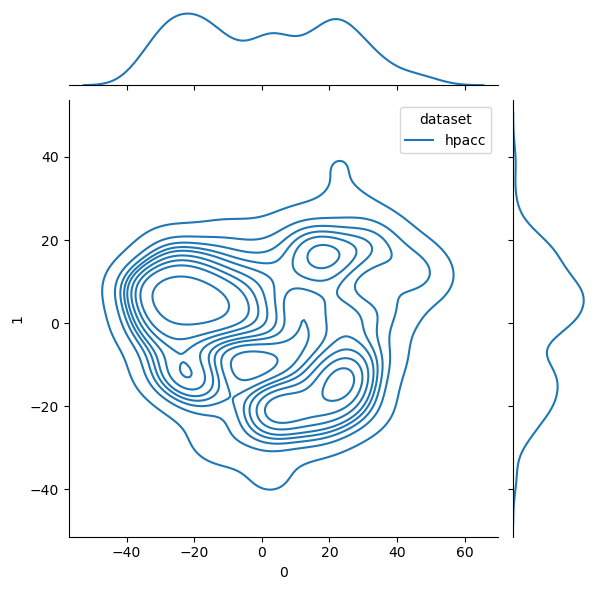

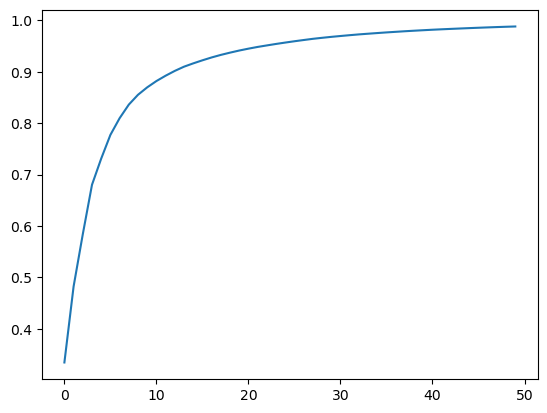

Number of PCs to explain 0.8 of the variance: 6


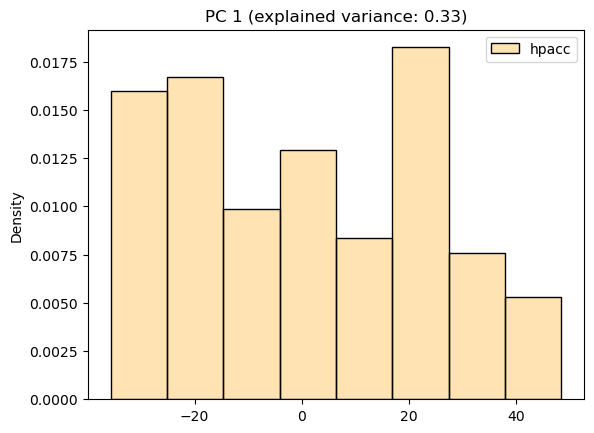

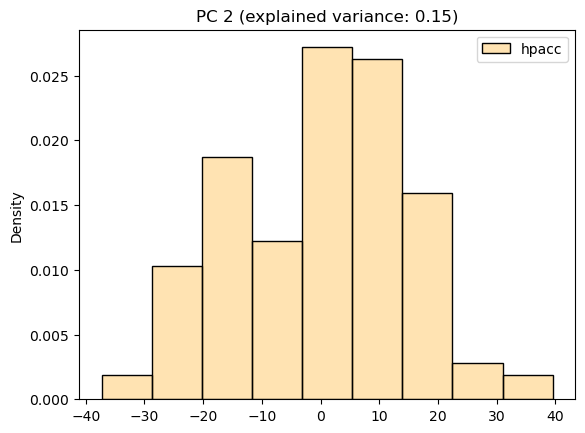

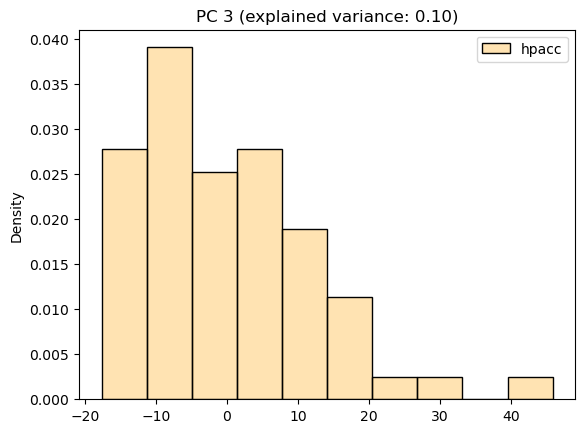

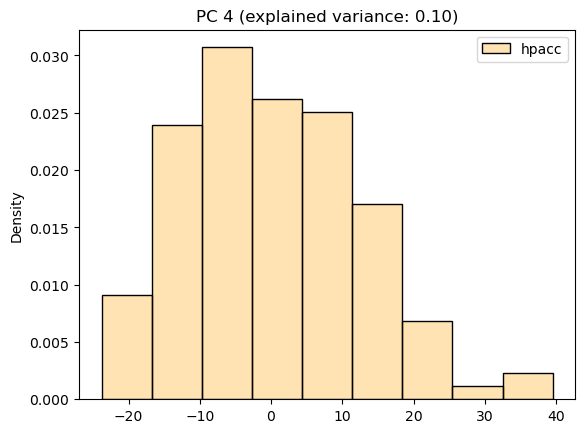

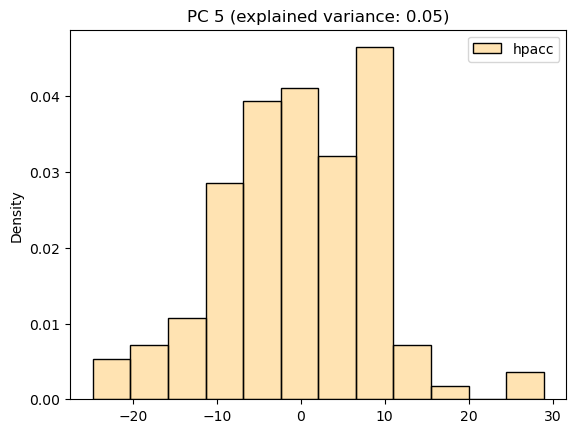

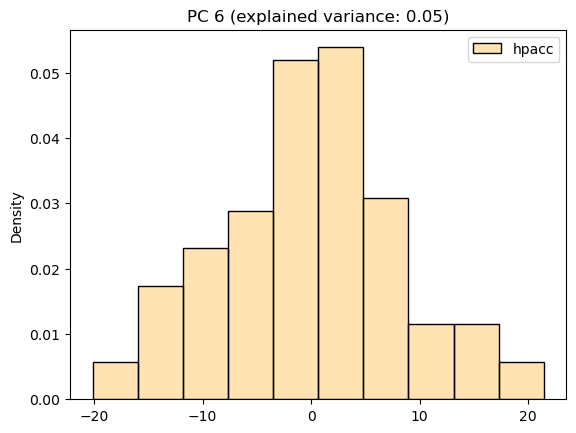

In [12]:
cutoff = 0.80
datasets_to_view = [
    # "fucci_norm",
    # "fucci_cham",
    # "fucci_tile",
    # "fucci_over",
    "hpacc",
    # "ccnb1"
]

# get an even number of samples from all datasets and use that to fit the scaler and pca
cls_tokens_all = []
for dataset in datasets_to_view:
    sample = np.random.choice(cls_tokens[dataset].shape[0], 1000, replace=True)
    cls_tokens_all.append(cls_tokens[dataset][sample])
cls_tokens_all = torch.concat(cls_tokens_all, dim=0)
scaler, pca = StandardScaler(), PCA(n_components=50)
scaled_cls_tokens_all = scaler.fit_transform(cls_tokens_all)
pca.fit(scaled_cls_tokens_all)


dataset_pca_tokens = {
    dataset: pca.transform(scaler.transform(cls_tokens[dataset])) for dataset in datasets_to_view
}

dataset_colors = {
    "fucci_norm": "purple",
    "fucci_cham": "blue",
    "fucci_tile": "red",
    "fucci_over": "green",
    "hpacc": "orange",
    "ccnb1": "orange"
}

dataset_samples = {
    dataset: np.random.choice(dataset_pca_tokens[dataset].shape[0], 1000, replace=True) for dataset in datasets_to_view
}

# make dataframe with pcs and dataset labels
df = pd.DataFrame(np.concatenate([dataset_pca_tokens[dataset][dataset_samples[dataset]] for dataset in datasets_to_view], axis=0))
df["dataset"] = np.concatenate([[dataset] * dataset_pca_tokens[dataset][dataset_samples[dataset]].shape[0] for dataset in datasets_to_view], axis=0)

plt.clf()
sns.jointplot(data=df, x=0, y=1, hue="dataset", kind="kde")
plt.show()

# plt.clf()
# for dataset in datasets_to_view:
#     sample = np.random.choice(dataset_pca_tokens[dataset].shape[0], 1000, replace=True)
#     plt.scatter(dataset_pca_tokens[dataset][sample, 0], dataset_pca_tokens[dataset][sample, 1], color=dataset_colors[dataset], label=dataset, alpha=0.1)
# plt.legend()
# plt.show()

plt.clf()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

cutoff_pcs = (pca.explained_variance_ratio_.cumsum() < cutoff).sum()
print(f"Number of PCs to explain {cutoff} of the variance: {cutoff_pcs}")

# plot histograms of all pcs until cutoff variance is explained
for i in range(cutoff_pcs):
    plt.clf()
    for dataset in datasets_to_view:
        sns.histplot(dataset_pca_tokens[dataset][:, i], color=dataset_colors[dataset], label=dataset, alpha=0.3, stat='density')
    plt.title(f"PC {i+1} (explained variance: {pca.explained_variance_ratio_[i]:.2f})")
    plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

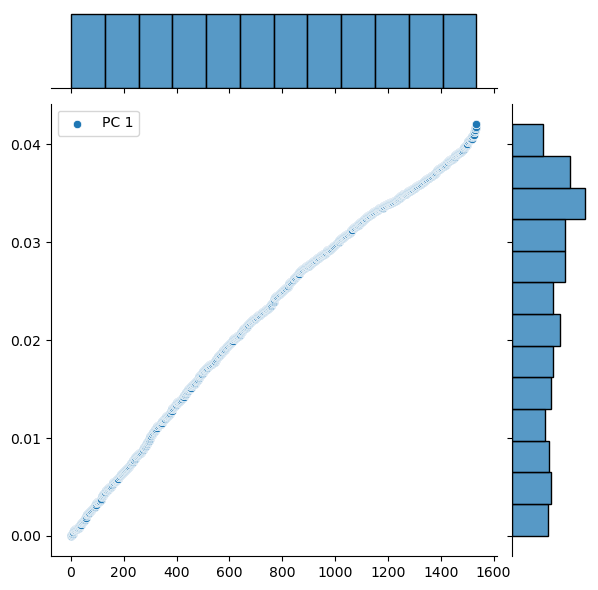

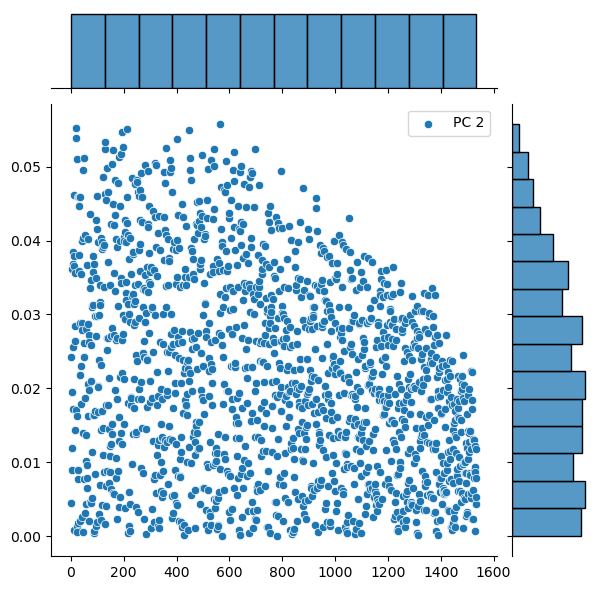

In [13]:
# plot the first two PCs
sorted_indices = np.argsort(np.abs(pca.components_[0]))
plt.clf()
for i in range(2):
    sns.jointplot(x=np.arange(len(pca.components_[i])), y=np.abs(pca.components_[i][sorted_indices]), label=f"PC {i+1}")
plt.legend()
plt.show()

In [14]:
# give the number of indices where the absolute value of the first PC is greater than 0.06 and the second PC is below 0.04
# or vice versa
upper = 0.04
lower = 0.02
forward = (np.abs(pca.components_[0]) > upper) & (np.abs(pca.components_[1]) < lower)
backward = (np.abs(pca.components_[0]) < lower) & (np.abs(pca.components_[1]) > upper)
total = forward | backward
print(total.sum())

159


# Pseudotime Distribution for each

In [13]:
# fucci_datasets = {
#     dataset: CellImageDataset(data_dirs[dataset] / f"index_{dataset_fileext[dataset]}.csv", batch_size=10) for dataset in fucci_datasets
# }
fucci_datasets = {
    dataset: datasets[dataset] for dataset in fucci_datasets
}

In [14]:
dataset_intensity_metrics = {}
for dataset in data_dirs:
    if dataset in fucci_datasets:
        print(f"Full intensity metrics for {dataset}")
        dataset_intensity_metrics[dataset] = get_intensity_metrics_sc(fucci_datasets[dataset], 1000)
    else:
        print(f"Ref intensity metrics for {dataset}")
        dataset_intensity_metrics[dataset] = get_intensity_metrics_sc(datasets[dataset], 1000)

Full intensity metrics for fucci


Computing mean intensities: 100%|██████████| 34/34 [00:49<00:00,  1.44s/it]


In [17]:
import pickle as pkl
import os

if os.path.exists("dataset_intensity_metrics.pkl"):
    with open("dataset_intensity_metrics.pkl", "rb") as f:
        try:
            cache = pkl.load(f)
            cache.update(dataset_intensity_metrics)
            dataset_intensity_metrics = cache
        except:
            pass

with open("dataset_intensity_metrics.pkl", "wb") as f:
    if len(dataset_intensity_metrics) > 0:
        pkl.dump(dataset_intensity_metrics, f)

EOFError: Ran out of input

In [ ]:
# for dataset in datasets:
    # print(torch.isnan(dataset_intensity_metrics[dataset][0]).any())
    # print(torch.isinf(dataset_intensity_metrics[dataset][0]).any())
    # print(torch.isneginf(dataset_intensity_metrics[dataset][0]).any())
    # print(torch.isnan(dataset_intensity_metrics[dataset][1]).any())
    # print(torch.isinf(dataset_intensity_metrics[dataset][1]).any())
    # print(torch.isneginf(dataset_intensity_metrics[dataset][1]).any())
    # print((dataset_intensity_metrics[dataset][1] == 0).any())
    # print((dataset_intensity_metrics[dataset][0][(dataset_intensity_metrics[dataset][1] == 0)] > 1).any())
    # print(dataset_intensity_metrics[dataset][0].shape, dataset_intensity_metrics[dataset][1].shape)

log_intensities = {
    dataset: np.log(dataset_intensity_metrics[dataset][0] / dataset_intensity_metrics[dataset][1]) for dataset in fucci_datasets
}

KeyError: 'fucci'

In [ ]:
fucci_cache_names = {
    dataset: data_dirs[dataset] / f"{dataset}_pseudotime.npy" for dataset in fucci_datasets
}

fucci_times = {
    dataset: intensities_to_polar_pseudotime(log_intensities[dataset][:, 2:].numpy()) for dataset in fucci_datasets
}

In [ ]:
for dataset in fucci_datasets:
    np.save(fucci_cache_names[dataset], fucci_times[dataset])

In [49]:
import pickle as pkl
dataset_intensity_metrics = pkl.load(open("dataset_intensity_metrics.pkl", "rb"))

In [50]:
fucci_cache_names = {
    dataset: data_dirs[dataset] / f"{dataset}_pseudotime.npy" for dataset in fucci_datasets
}
fucci_times = {}
for dataset in fucci_datasets:
    fucci_times[dataset] = np.load(fucci_cache_names[dataset])

<Figure size 640x480 with 0 Axes>

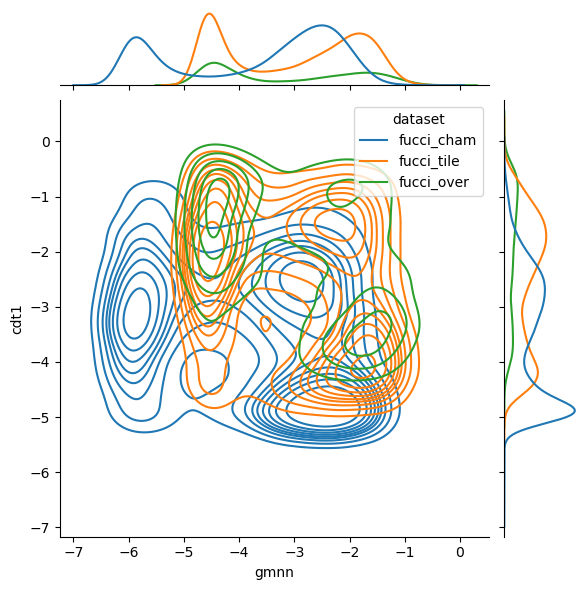

In [24]:
datasets_to_view = [
    # "fucci_norm",
    "fucci_cham",
    "fucci_tile",
    "fucci_over",
]

gmnn_intensities, cdt1_intensities = [], []
for dataset in fucci_datasets:
    # print(torch.isnan(log_intensities[dataset]).any())
    # print(torch.isinf(log_intensities[dataset]).any())
    # print(torch.isneginf(log_intensities[dataset]).any())
    gmnn_intensities.append(log_intensities[dataset][:, 2])
    cdt1_intensities.append(log_intensities[dataset][:, 3])
gmnn_intensities = np.concatenate(gmnn_intensities)
cdt1_intensities = np.concatenate(cdt1_intensities)
dataset_label = np.concatenate([[dataset] * log_intensities[dataset].shape[0] for dataset in fucci_datasets])

df = pd.DataFrame(np.stack([gmnn_intensities, cdt1_intensities, dataset_label], axis=1), columns=["gmnn", "cdt1", "dataset"])
df["gmnn"] = df["gmnn"].astype(float)
df["cdt1"] = df["cdt1"].astype(float)
df["dataset"] = df["dataset"].astype(str)

# filter to only shows datasets in datasets_to_view
df_view = df[df["dataset"].isin(datasets_to_view)]

plt.clf()
sns.jointplot(data=df_view, x="gmnn", y="cdt1", hue="dataset", kind="kde")
plt.show()

In [25]:
cls_caches = {
    dataset: data_dirs[dataset] / f"{dataset}_HPA_DINO_cls_concat_tokens.pt" for dataset in data_dirs.keys()
}

cls_tokens = {
    dataset: torch.load(cls_caches[dataset]) for dataset in data_dirs
}

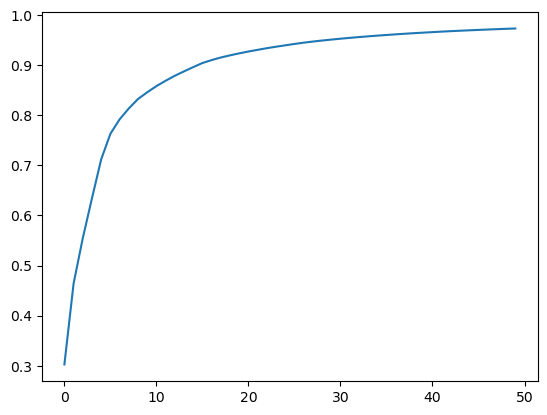

<Figure size 640x480 with 0 Axes>

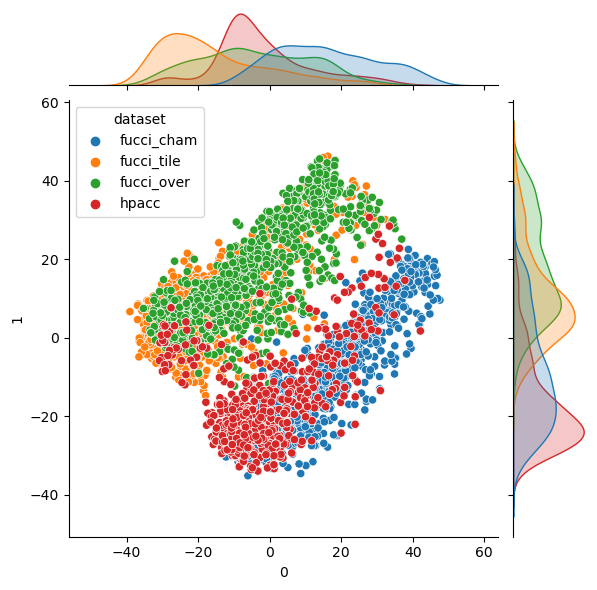

<Figure size 640x480 with 0 Axes>

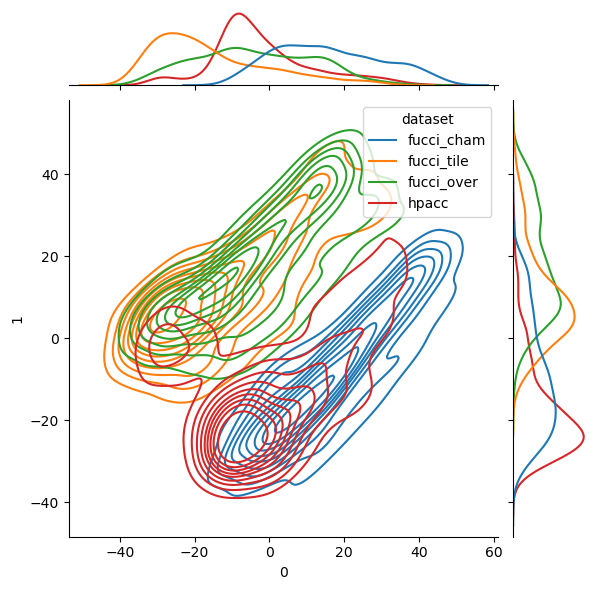

<Figure size 640x480 with 0 Axes>

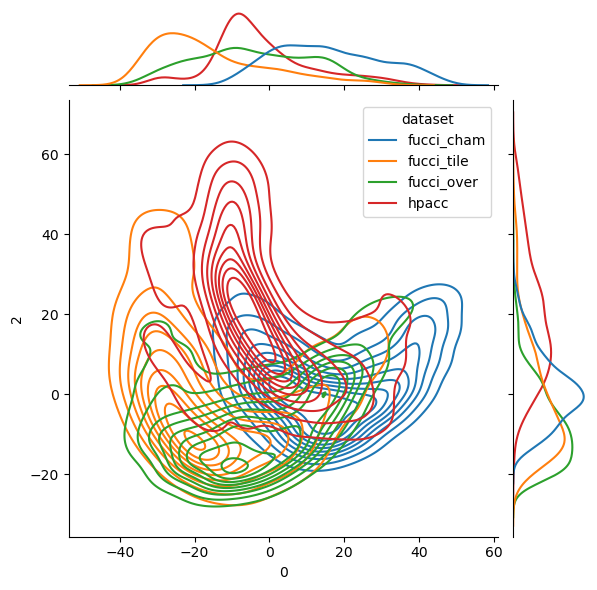

<Figure size 640x480 with 0 Axes>

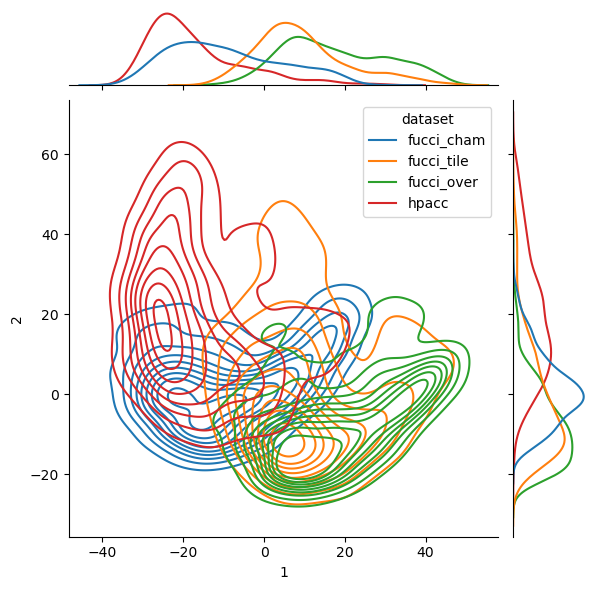

In [26]:
# plot PCA of cls tokens colored by FUCCI pseudotime

data_pca = [
    "fucci_cham",
    "fucci_tile",
    # "fucci_over",
    # "hpacc",
]

data_view = [
    # "fucci_norm",
    "fucci_cham",
    "fucci_tile",
    "fucci_over",
    "hpacc",
    # "ccnb1"
]

samples = {
    dataset: np.random.choice(cls_tokens[dataset].shape[0], 900, replace=True) for dataset in data_dirs
}

scaler, pca = StandardScaler(), PCA(n_components=50)
scaler.fit(np.concatenate([cls_tokens[dataset][samples[dataset]] for dataset in data_pca], axis=0))
scaled_cls_tokens = {
    dataset: scaler.transform(cls_tokens[dataset][samples[dataset]]) for dataset in data_dirs
}
pca.fit(np.concatenate([scaled_cls_tokens[dataset] for dataset in data_pca], axis=0))
pca_cls_tokens = {
    dataset: pca.transform(scaled_cls_tokens[dataset]) for dataset in data_dirs
}

# plt.clf()
# for dataset in data_dirs:
#     plt.scatter(pca_cls_tokens[dataset][:, 0], pca_cls_tokens[dataset][:, 1], label=dataset, alpha=0.1)
# plt.legend()
# plt.show()

plt.clf()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

df = pd.DataFrame(np.concatenate([pca_cls_tokens[dataset] for dataset in data_view], axis=0))
df["dataset"] = np.concatenate([[dataset] * pca_cls_tokens[dataset].shape[0] for dataset in data_view], axis=0)
plt.clf()
sns.jointplot(data=df, x=0, y=1, hue="dataset")
plt.show()
plt.clf()
sns.jointplot(data=df, x=0, y=1, hue="dataset", kind="kde")
plt.show()
plt.clf()
sns.jointplot(data=df, x=0, y=2, hue="dataset", kind="kde")
plt.show()
plt.clf()
sns.jointplot(data=df, x=1, y=2, hue="dataset", kind="kde")
plt.show()

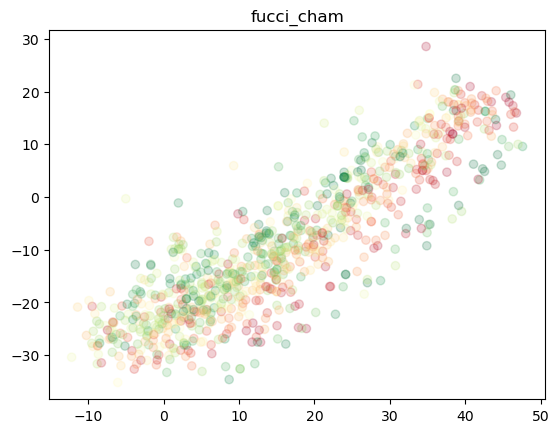

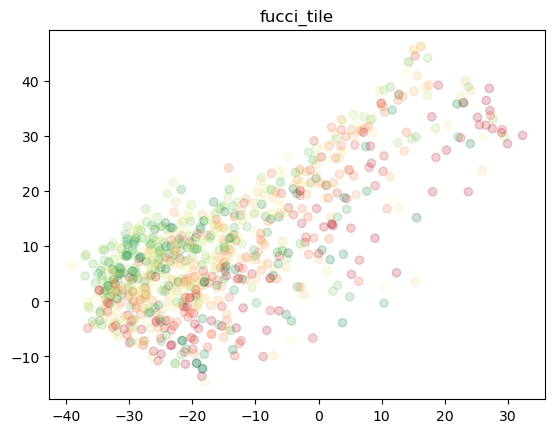

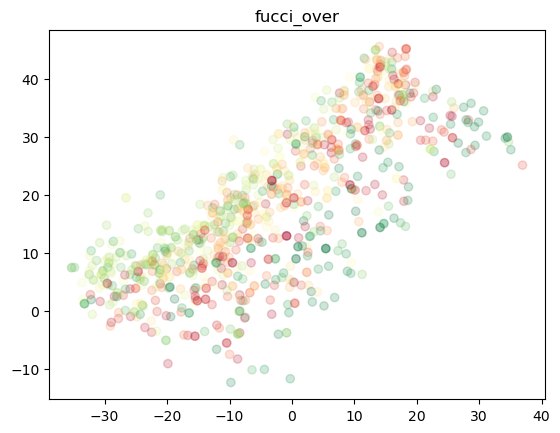

In [27]:
for dataset in fucci_datasets:
    plt.clf()
    plt.scatter(pca_cls_tokens[dataset][:, 0], pca_cls_tokens[dataset][:, 1], c=fucci_times[dataset][samples[dataset]], alpha=0.2, cmap="RdYlGn")
    # sizes = dataset_intensity_metrics[dataset][1][samples[dataset]]
    # sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min())
    # sizes = torch.max(sizes, dim=1).values
    # plt.scatter(pca_cls_tokens[dataset][:, 0], pca_cls_tokens[dataset][:, 1], c=sizes, alpha=0.2, cmap="RdYlGn")
    plt.title(dataset)
    plt.show()

# Pseudotime Dataset Dependency

In [25]:
def plot_marker_cycle(gmnn, cdt1, pseudotime, dataset, pst_bins=100, ci=False, interval=95):
    df = pd.DataFrame(np.stack([gmnn, cdt1, pseudotime], axis=1), columns=["gmnn", "cdt1", "pseudotime"])
    df["gmnn"] = df["gmnn"].astype(float)
    df["cdt1"] = df["cdt1"].astype(float)
    df["pseudotime"] = df["pseudotime"].astype(float)

    if not pst_bins is None:
        df["pseudotime"] = pd.cut(df["pseudotime"], pst_bins, labels=False)
    
    plt.clf()
    ax = sns.lineplot(data=df, x="pseudotime", y="gmnn", label="GMNN", errorbar=('ci' if ci else 'pi', interval), legend=False, color="green")
    ax2 = ax.twinx()
    sns.lineplot(data=df, x="pseudotime", y="cdt1", label="CDT1", errorbar=('ci' if ci else 'pi', interval), legend=False, color="red")
    plt.title(f"FUCCI vs Pseudotime for {dataset} ({'CI' if ci else 'PI'} {interval}%)")
    ax.set_xlabel("FUCCI pseudotime")
    ax.figure.legend()
    plt.show()



In [ ]:
for dataset in fucci_datasets:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times[dataset], dataset, 
                      ci=False, interval=75)

In [ ]:
fucci_times_shifted = {
    "fucci_cham": fucci_times["fucci_cham"] + 0.012,
    "fucci_tile": fucci_times["fucci_tile"] + 0.01,
    "fucci_over": fucci_times["fucci_over"] + 0.05,
}

fucci_times_shifted = {
    dataset: fucci_times_shifted[dataset] % 1.0 for dataset in fucci_times_shifted
}

for dataset in fucci_times_shifted:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times_shifted[dataset], dataset,
                      ci=False, interval=75, pst_bins=100)

In [ ]:
fucci_times_center = {
    "fucci_cham": 0.40,
    "fucci_tile": 0.58,
    "fucci_over": 0.625
}


fucci_times_centered = {
    dataset: np.where(fucci_times_shifted[dataset] > fucci_times_center[dataset],
                    (fucci_times_shifted[dataset] - fucci_times_center[dataset]) / (1 - fucci_times_center[dataset]) * 0.5 + 0.5,
                    fucci_times_shifted[dataset] / fucci_times_center[dataset] * 0.5)
    for dataset in fucci_times_shifted
}


for dataset in fucci_times_centered:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times_centered[dataset], dataset, 
                      ci=False, interval=75, pst_bins=100)

# FUCCI Dynamics

In [ ]:
fucci_dynamics_file = Path("~/HPA-embedding/FUCCI cell cycle tracking.csv")
dyn_df = pd.read_csv(fucci_dynamics_file)
N = "TRACK_ID"
T = "POSITION_T"
GMNN = "MEAN_INTENSITY_CH2"
CDT1 = "MEAN_INTENSITY_CH1"
columns = [N, T, GMNN, CDT1]
dyn_df = dyn_df[columns]
dyn_df = dyn_df[dyn_df.index > 2]
dyn_df = dyn_df.dropna()
dyn_df[N] = dyn_df[N].astype(int)
dyn_df[T] = dyn_df[T].astype(float)
dyn_df[GMNN] = np.log10(dyn_df[GMNN].astype(float))
dyn_df[CDT1] = np.log10(dyn_df[CDT1].astype(float))
dyn_df.head()

In [ ]:
print(dyn_df[N].unique().shape)
print(dyn_df[T].min(), dyn_df[T].max())

In [ ]:
# plot the mean intensity of channels 2 and 3 for each track
plt.clf()
for track in dyn_df[N].unique():
    track_df = dyn_df[dyn_df[N] == track]
    # place a dot at the start of the track
    # plt.scatter(track_df[GMNN].iloc[0], track_df[CDT1].iloc[0], color="black")
    # color the line by the time
    time_series = (track_df[T].values - track_df[T].values.min()) / (track_df[T].values.max() - track_df[T].values.min())
    plt.scatter(track_df[GMNN], track_df[CDT1], color=plt.cm.RdYlGn(time_series))
plt.title(f"FUCCI dynamics")
plt.xlabel("GMNN Mean Intensity")
plt.ylabel("CDT1 Mean Intensity")
plt.show()

In [ ]:
log_intensities = np.stack([dyn_df[GMNN], dyn_df[CDT1]], axis=1)
pseudotime = intensities_to_polar_pseudotime(log_intensities, center=np.array([0.8, 0.4]))

plt.clf()
plt.scatter(dyn_df[GMNN], dyn_df[CDT1], c=pseudotime, cmap="RdYlGn")
plt.title(f"FUCCI pseudotime")
plt.xlabel("GMNN Mean Intensity")
plt.ylabel("CDT1 Mean Intensity")
plt.show()

In [ ]:
plt.clf()
for track in dyn_df[N].unique():
    track_ps = pseudotime[dyn_df[N] == track]
    track_df = dyn_df[dyn_df[N] == track]
    start_t = track_df[T].iloc[0]
    time_series = track_df[T] - start_t
    plt.plot(track_ps, time_series)
plt.title(f"FUCCI pseudotime")
plt.xlabel("Pseudotime")
plt.ylabel("Time")
plt.show()

In [ ]:
# make 100 bins for pseudotime
# plot the distribution of the slope of real time vs pseudotime for each bin
# the x axis will be pseudotime (binned), and the y will be the distribution of slopes

pst_bins = 10
dyn_df_binned = dyn_df.copy()
dyn_df_binned["pseudotime"] = pd.cut(pseudotime, pst_bins, labels=False)

slopes = [[] for _ in range(pst_bins)]
t_deltas, ps_deltas = [], []

for track in dyn_df_binned[N].unique():
    track_ps = pseudotime[dyn_df_binned[N] == track]
    track_df = dyn_df[dyn_df_binned[N] == track]
    track_t = track_df[T]
    start_t = track_t.iloc[0]
    track_t = track_t - start_t
    track_t = np.asarray(track_t)
    track_slope = (track_t[1:] - track_t[:-1]) / (track_ps[1:] - track_ps[:-1] + 1e-5)
    t_deltas.append(track_t[1:] - track_t[:-1])
    ps_deltas.append(track_ps[1:] - track_ps[:-1])
    for i in range(len(track_slope)):
        slopes[dyn_df_binned["pseudotime"][dyn_df_binned[N] == track].iloc[i]].append(track_slope[i])

slopes = [np.array(slope) for slope in slopes]
print([np.sum(np.isnan(slope)) for slope in slopes])
slopes = [slope[~np.isnan(slope)] for slope in slopes]
print([np.sum(np.isinf(slope)) for slope in slopes])
slopes = [slope[~np.isinf(slope)] for slope in slopes]

t_deltas = np.concatenate(t_deltas)
ps_deltas = np.concatenate(ps_deltas)

# make a histogram of the ps_deltas and the t_deltas
plt.clf()
sns.histplot(t_deltas)
plt.legend()
plt.title("Real time deltas")
plt.xlabel("Time delta")
plt.ylabel("Count")
plt.show()

plt.clf()
sns.histplot(ps_deltas)
plt.legend()
plt.title("Pseudotime deltas")
plt.xlabel("Pseudotime delta")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

# make a scatter plot of ps_deltas against t_deltas
plt.clf()
plt.scatter(ps_deltas, t_deltas)
plt.title("Pseudotime deltas vs real time deltas")
plt.xlabel("Pseudotime delta")
plt.ylabel("Real time delta")
plt.show()

# make a histogram of the slopes for each bin as a violin plot
plt.clf()
scaled_slopes = [slope / (25 * 3600) for slope in slopes]
sns.violinplot(data=scaled_slopes)
plt.title("Slope distribution for each pseudotime bin")
plt.xlabel("Pseudotime bin")
plt.ylabel("Slope (s real / s pseudo)")
plt.show()

# Pseudotime Sector Labels

In [54]:
import pickle as pkl
dataset_intensity_metrics = pkl.load(open(DATA"dataset_intensity_metrics.pkl", "rb"))

log_intensities = {
    dataset: np.log(dataset_intensity_metrics[dataset][0] / dataset_intensity_metrics[dataset][1]) for dataset in fucci_datasets
}

fucci_cache_names = {
    dataset: data_dirs[dataset] / f"{dataset}_pseudotime.npy" for dataset in fucci_datasets
}
fucci_times = {}
for dataset in fucci_datasets:
    fucci_times[dataset] = np.load(fucci_cache_names[dataset])

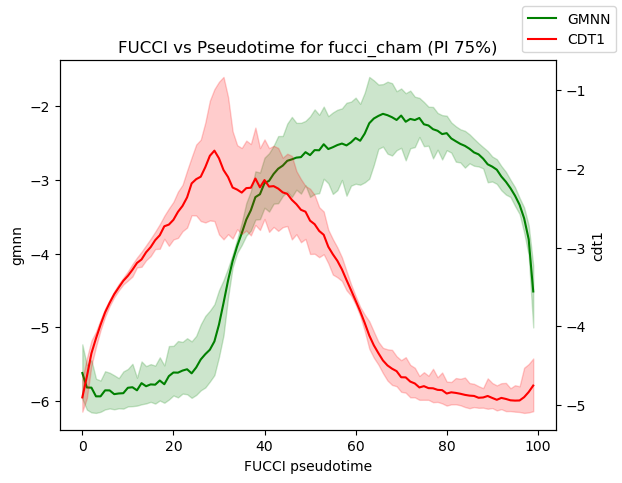

<Figure size 640x480 with 0 Axes>

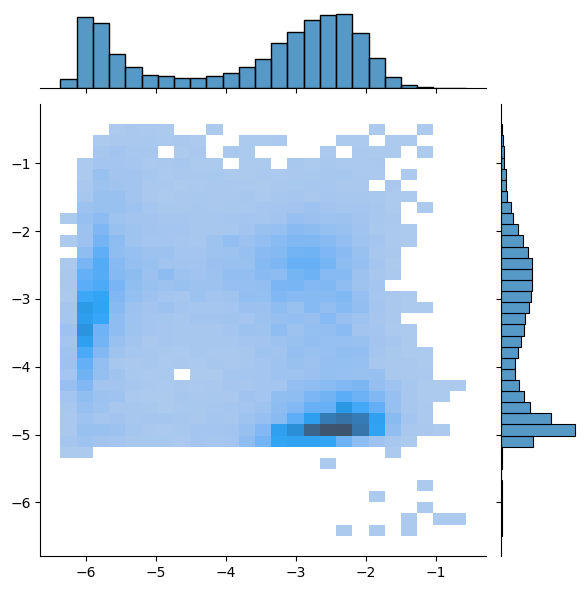

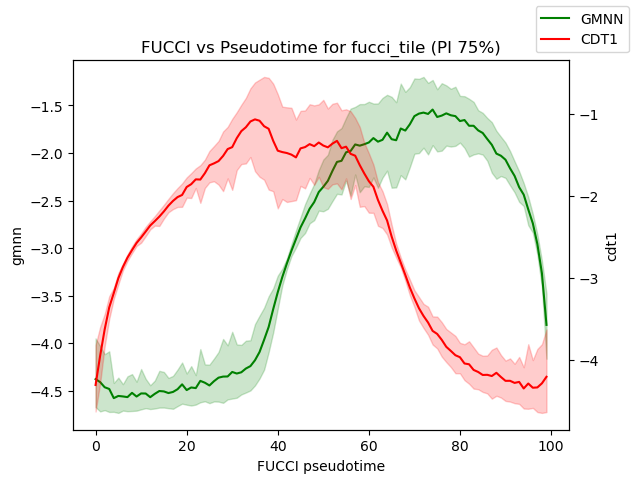

<Figure size 640x480 with 0 Axes>

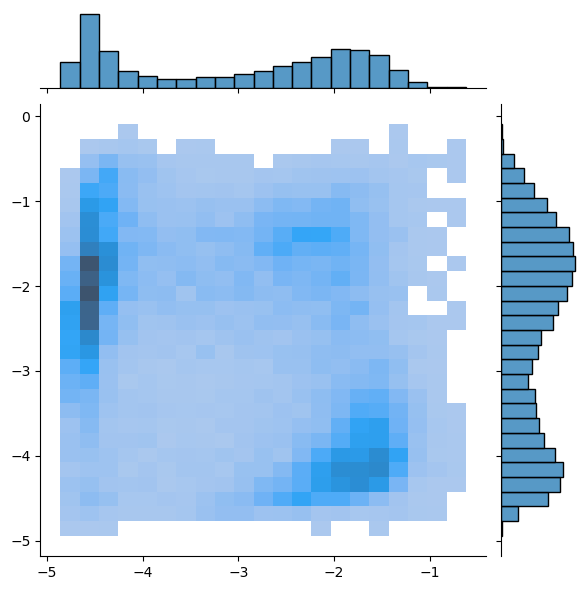

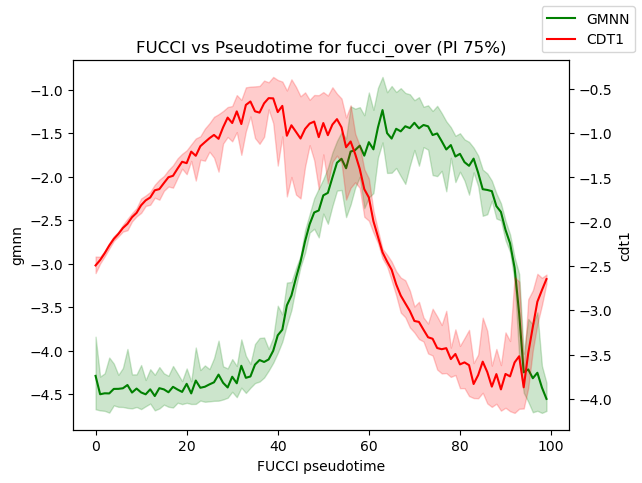

<Figure size 640x480 with 0 Axes>

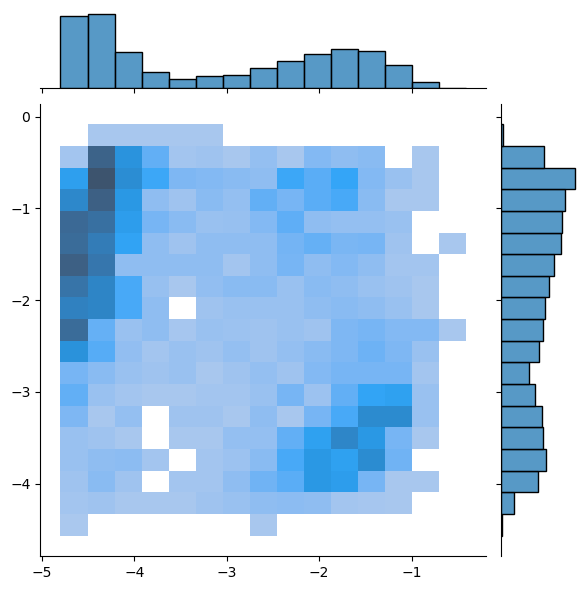

In [55]:
for dataset in fucci_datasets:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times[dataset], dataset, 
                      ci=False, interval=75)
    plt.clf()
    sns.jointplot(x=log_intensities[dataset][:, 2], y=log_intensities[dataset][:, 3], kind="hist")
    plt.show()


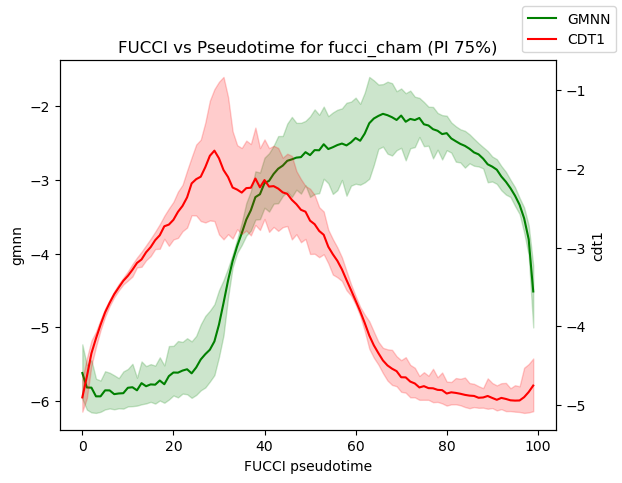

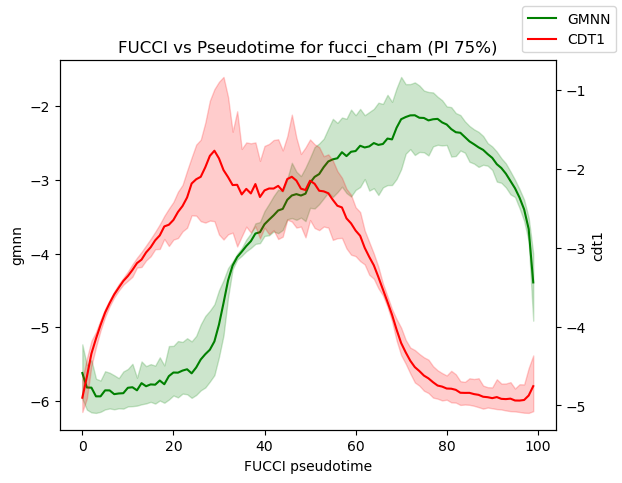

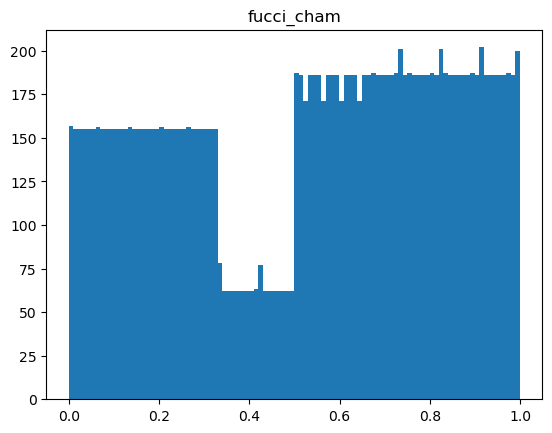

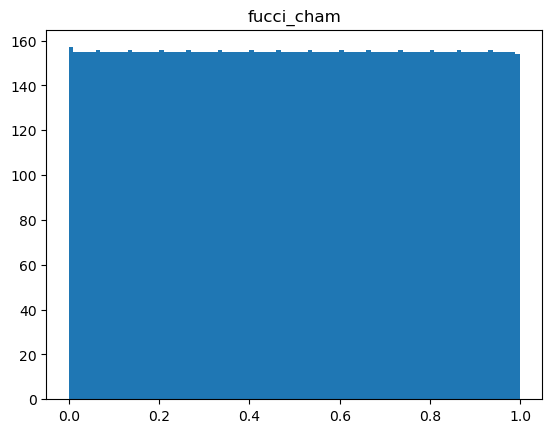

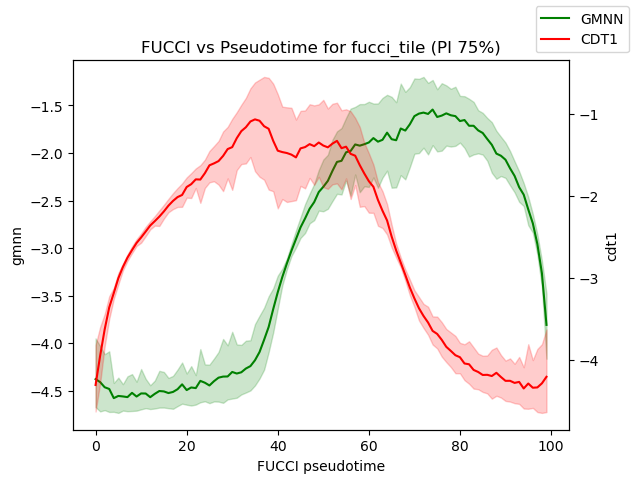

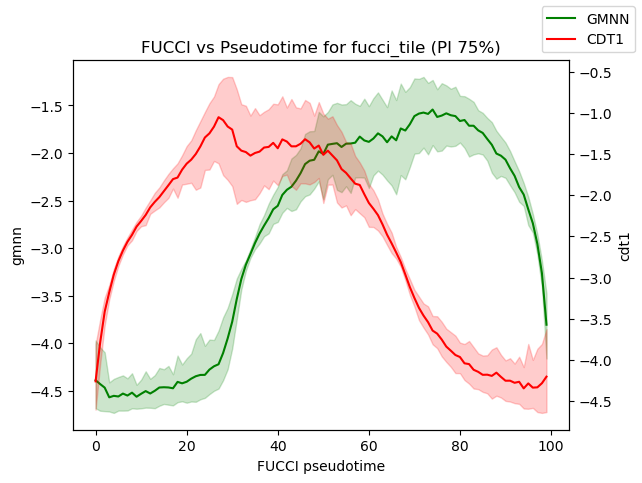

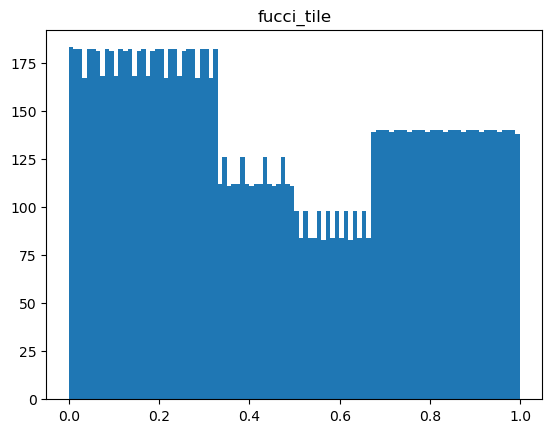

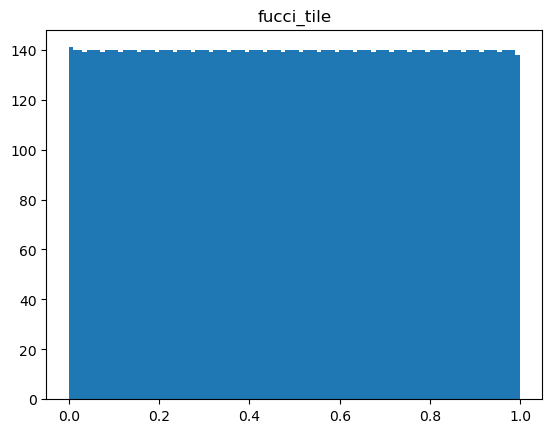

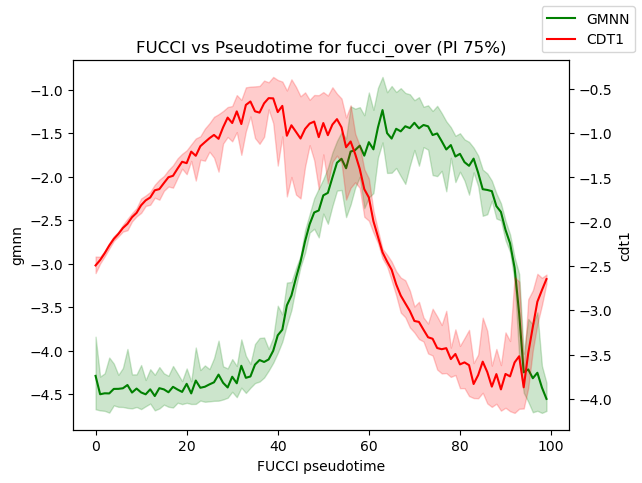

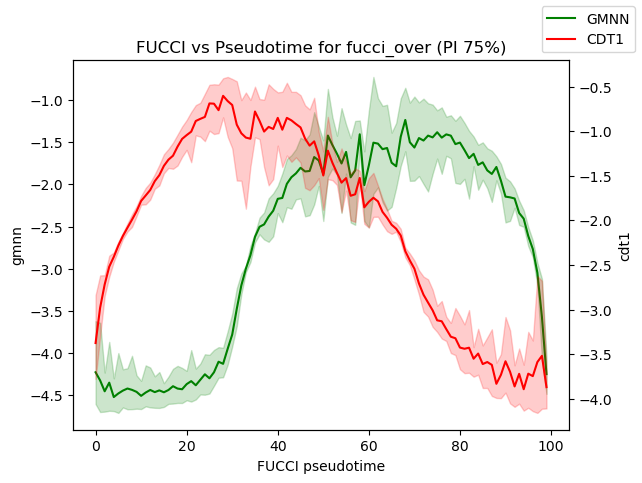

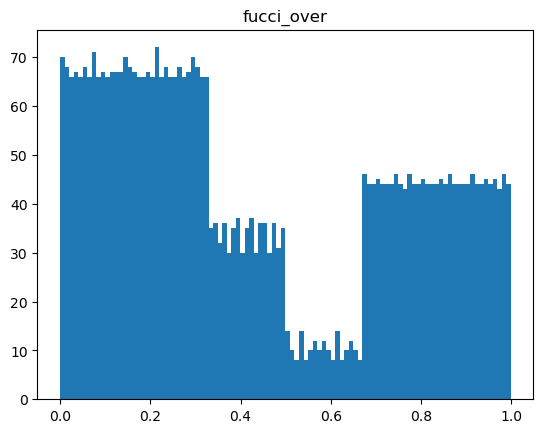

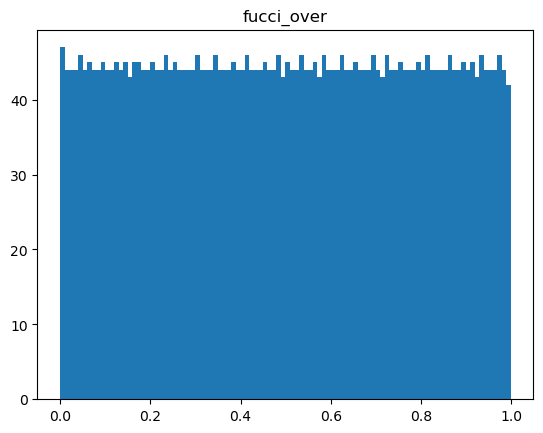

In [56]:
fucci_time_nodes = {
    # "fucci_cham": [0.05, 0.35, 0.60, 1.00],
    # "fucci_tile": [0.07, 0.42, 0.70, 1.00],
    # "fucci_over": [0.07, 0.50, 0.65, 0.98],
    "fucci_cham": [0.00, 0.33, 0.40, 0.60, 1.00],
    "fucci_tile": [0.00, 0.42, 0.56, 0.67, 1.00],
    "fucci_over": [0.00, 0.45, 0.58, 0.62, 1.00],
}

remap = [0.00, 0.33, 0.50, 0.67, 1.00]

def map_times(nodes, times):
    new_times = times.copy()
    # new_times[times < nodes[0]] = remap[0]
    # new_times[times > nodes[-1]] = remap[-1]
    # new_times = np.interp(new_times, nodes, remap, period=1.0)
    for i in range(len(nodes) - 1):
        indices = (times >= nodes[i]) & (times < nodes[i + 1])
        new_times[indices] = remap[i] + (times[indices] - nodes[i]) / (nodes[i + 1] - nodes[i]) * (remap[i + 1] - remap[i])
    return new_times

shifts = {
    "fucci_cham": 0.0,
    "fucci_tile": 0.0,
    "fucci_over": 0.05,
}

fucci_times_shifted = {
    dataset: (fucci_times[dataset] + shifts[dataset]) % 1.0 for dataset in fucci_times
}

fucci_time_nodes = {
    dataset: (np.array(fucci_time_nodes[dataset]) + shifts[dataset]) % 1.0 for dataset in fucci_time_nodes
}

for dataset, nodes in fucci_time_nodes.items():
    fucci_time_nodes[dataset][0] = 0.00
    fucci_time_nodes[dataset][-1] = 1.00


fucci_times_remap = {
    dataset: map_times(fucci_time_nodes[dataset], fucci_times_shifted[dataset]) for dataset in fucci_times_shifted
}

for dataset in fucci_times_remap:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times[dataset], dataset, 
                      ci=False, interval=75, pst_bins=100)
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times_remap[dataset], dataset, 
                      ci=False, interval=75, pst_bins=100)
    plt.clf()
    plt.hist(fucci_times_remap[dataset], bins=100)
    plt.title(dataset)
    plt.show()
    plt.clf()
    plt.hist(fucci_times[dataset], bins=100)
    plt.title(dataset)
    plt.show()

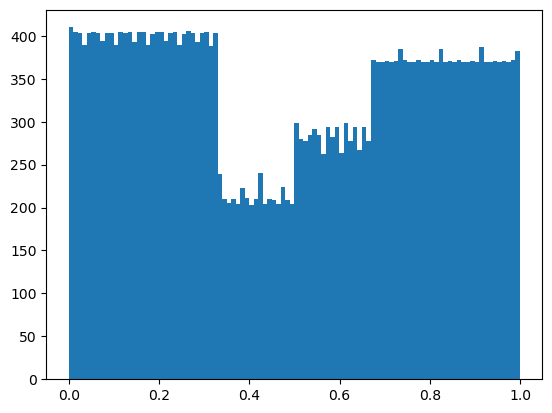

In [58]:
plt.hist(np.concatenate([fucci_times_remap[dataset] for dataset in fucci_times_remap]), bins=100)
plt.show()

In [32]:
# write the fucci pseudotimes to files
fucci_cache_names = {
    dataset: data_dirs[dataset] / f"{dataset}_pseudotime_normalized.npy" for dataset in fucci_datasets
}

for dataset in fucci_datasets:
    np.save(fucci_cache_names[dataset], fucci_times_remap[dataset])

In [63]:
for dataset in fucci_datasets:
    print(dataset, len(fucci_times_remap[dataset]))

fucci_cham 15515
fucci_tile 13975
fucci_over 4443


## Old other stuff

In [ ]:
fucci_pseudotimes = []
index = {
    dataset: 0 for dataset in fucci_datasets
}

name_to_dataset = {
    "chamber": "fucci_cham",
    "tilescan": "fucci_tile",
    "overview": "fucci_over"
}

for row in FUCCI_index.iterrows():
    for name in name_to_dataset:
        if name in row[1][0]:
            dataset = name_to_dataset[name]
            mask = torch.load(row[1][2])
            num_cells = mask.shape[0]
            fucci_pseudotimes.append(fucci_times_remap[dataset][index[dataset]:index[dataset] + num_cells])
            index[dataset] += num_cells
            break

fucci_pseudotimes = np.concatenate(fucci_pseudotimes)
    
print(row)
print(dataset)
print(len(fucci_pseudotimes))
print(index)

In [ ]:
np.save(FUCCI_DATA_DIR / "FUCCI_pseudotime_normalized.npy", fucci_pseudotimes)

In [ ]:
plt.hist(fucci_pseudotimes, bins=100)

In [ ]:
for dataset in fucci_times_remap:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times_remap[dataset], dataset, 
                      ci=False, interval=75, pst_bins=100)

In [ ]:
mitosis_delta = {
    "fucci_cham": 0.00,
    "fucci_tile": 0.01,
    "fucci_over": 0.05,
}

fucci_times_shifted = {
    dataset: (fucci_times[dataset] + mitosis_delta[dataset]) % 1.0 for dataset in fucci_times
}

for dataset in fucci_times_shifted:
    plot_marker_cycle(log_intensities[dataset][:, 2], log_intensities[dataset][:, 3], fucci_times_shifted[dataset], dataset, 
                      ci=False, interval=75, pst_bins=100)

In [ ]:
# defining the left boundary of the G1 phase in log intensity space (cutoff is for GMNN)
G1_cutoffs = {
    "fucci_cham": -4.25,
    "fucci_tile": -3.5,
    "fucci_over": -3.33,
}

# defining a CDT1 cutoff below which we'll call in G2/M, above which we'll call it G1/S
G2_cutoffs = {
    "fucci_cham": -3.75,
    "fucci_tile": -2.67,
    "fucci_over": -1.9
}

fucci_labels = {
    dataset: np.where(log_intensities[dataset][:, 2] < G1_cutoffs[dataset], 0,
                      np.where(log_intensities[dataset][:, 3] > G2_cutoffs[dataset], 1, 2))
    for dataset in G1_cutoffs
}

for dataset in fucci_labels:
    np.save(data_dirs[dataset] / f"{dataset}_cutoff_fucci_labels.npy", fucci_labels[dataset])

In [ ]:
for dataset in fucci_labels:
    plt.clf()
    plt.scatter(pca_cls_tokens[dataset][:, 0], pca_cls_tokens[dataset][:, 1], c=fucci_labels[dataset][samples[dataset]], alpha=0.2, cmap="RdYlGn")
    plt.title(dataset)
    plt.show()

# Perfect Model Performance

In [7]:
# load log intensities and fucci pseudotimes for each fucci_dataset
log_intensities = {
    dataset: np.log(dataset_intensity_metrics[dataset][0] / dataset_intensity_metrics[dataset][1]) for dataset in fucci_datasets
}

fucci_pseudotimes = {
    dataset: np.load(data_dirs[dataset] / f"{dataset}_pseudotime_normalized.npy") for dataset in fucci_datasets
}

NameError: name 'dataset_intensity_metrics' is not defined

<Figure size 640x480 with 0 Axes>

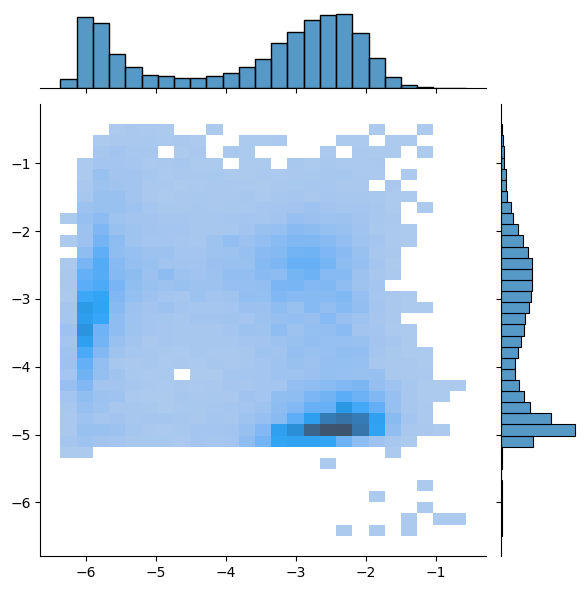

<Figure size 640x480 with 0 Axes>

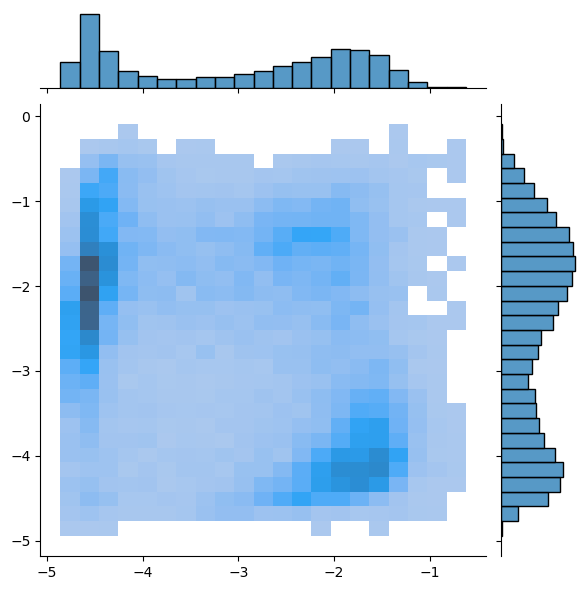

<Figure size 640x480 with 0 Axes>

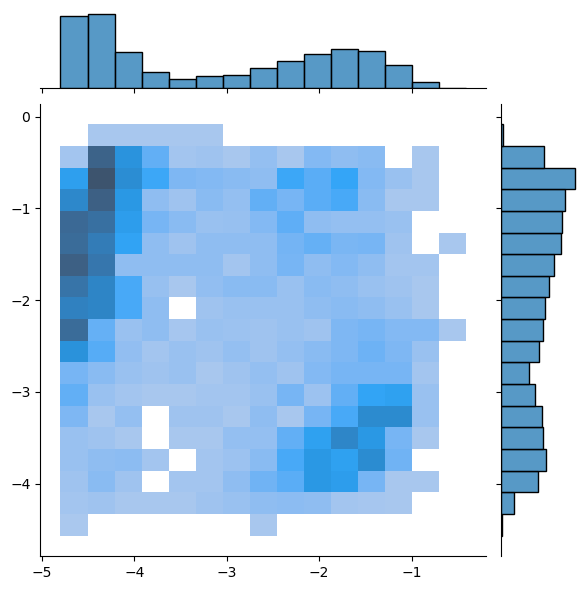

In [ ]:
for dataset in log_intensities:
    plt.clf()
    sns.jointplot(x=log_intensities[dataset][:, 2], y=log_intensities[dataset][:, 3], kind="hist")
    plt.show()

<Figure size 640x480 with 0 Axes>

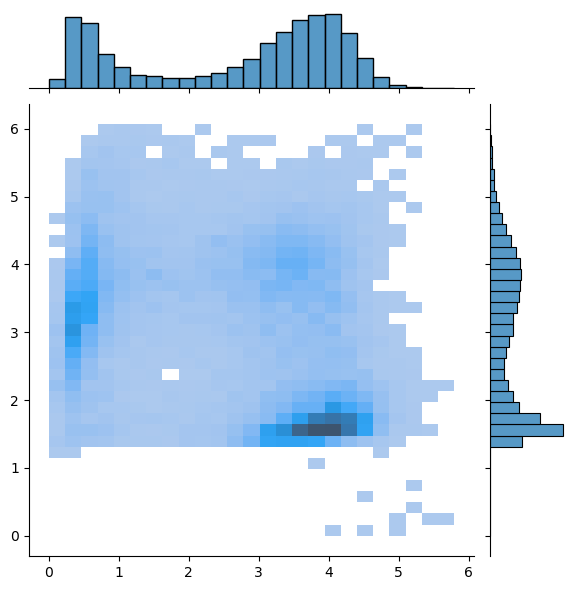

<Figure size 640x480 with 0 Axes>

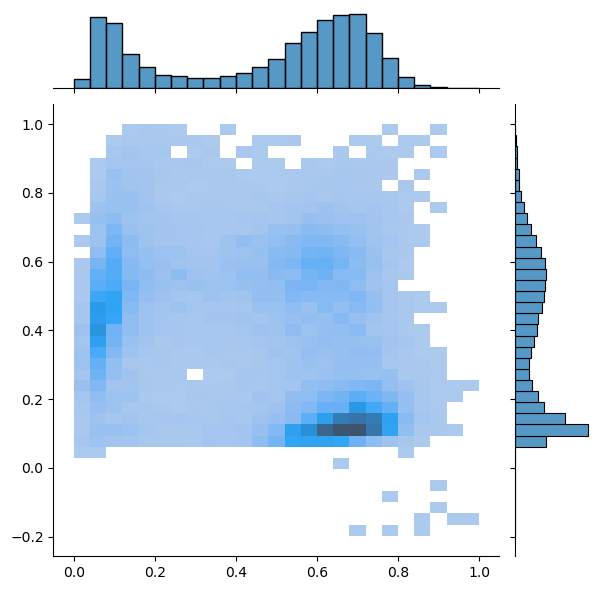

<Figure size 640x480 with 0 Axes>

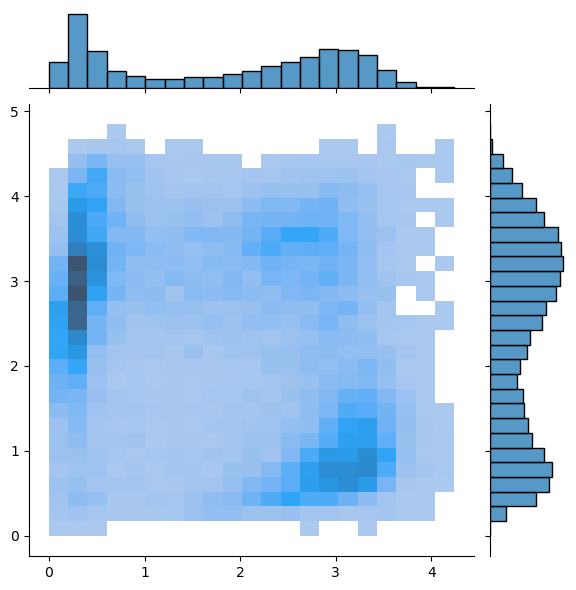

<Figure size 640x480 with 0 Axes>

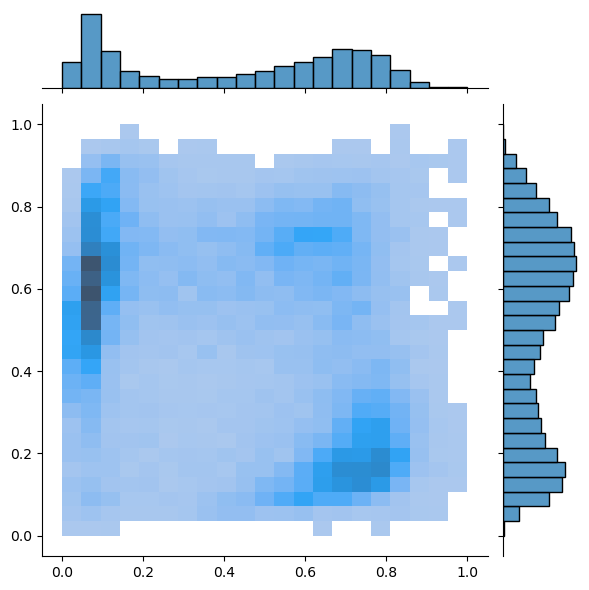

<Figure size 640x480 with 0 Axes>

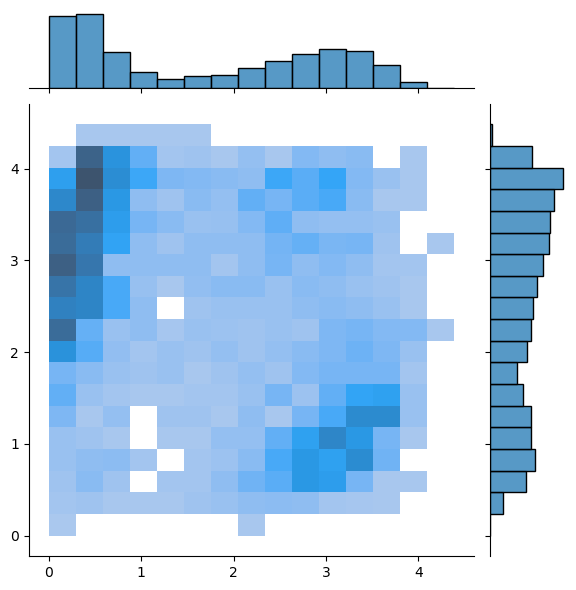

<Figure size 640x480 with 0 Axes>

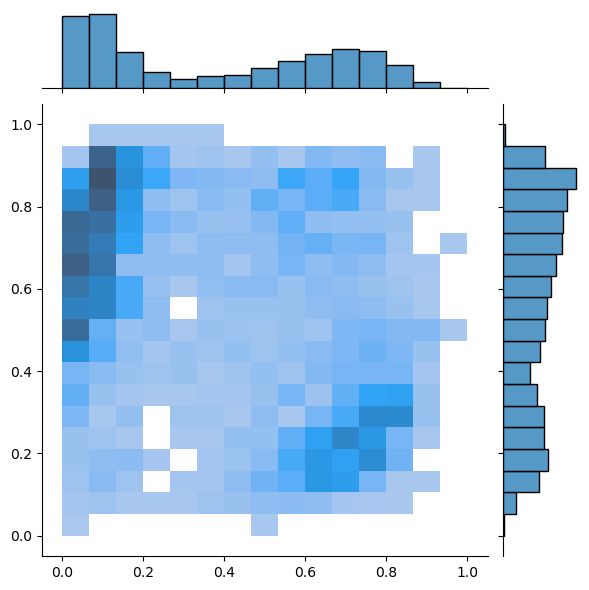

In [ ]:
rescaled_log_intensities = {}
for dataset in log_intensities:
    fucci_intensities = log_intensities[dataset][:, 2:]
    fucci_intensities = fucci_intensities - fucci_intensities.min(axis=0).values
    plt.clf()
    sns.jointplot(x=fucci_intensities[:, 0], y=fucci_intensities[:, 1], kind="hist")
    plt.show()
    if dataset == "fucci_cham":
        fucci_intensities[:, 1] = fucci_intensities[:, 1] - 1.0
    fucci_intensities = fucci_intensities / fucci_intensities.max(axis=0).values
    plt.clf()
    sns.jointplot(x=fucci_intensities[:, 0], y=fucci_intensities[:, 1], kind="hist")
    plt.show()
    rescaled_log_intensities[dataset] = fucci_intensities


<Figure size 640x480 with 0 Axes>

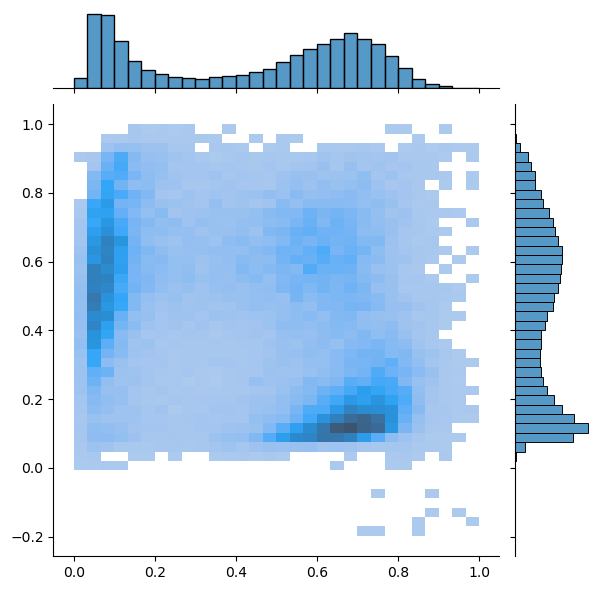

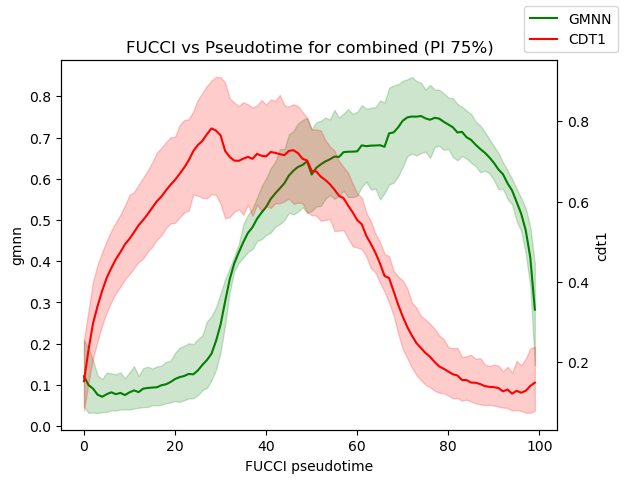

In [ ]:
# combine them all into a single comb_log_intensities and comb_pseudotimes
comb_log_intensities = np.concatenate([rescaled_log_intensities[dataset] for dataset in rescaled_log_intensities], axis=0)
comb_pseudotimes = np.concatenate([fucci_pseudotimes[dataset] for dataset in fucci_pseudotimes], axis=0)

# plot the comb_log_intensities and comb_pseudotimes
plt.clf()
sns.jointplot(x=comb_log_intensities[:, 0], y=comb_log_intensities[:, 1], kind="hist")
plt.show()

plot_marker_cycle(comb_log_intensities[:, 0], comb_log_intensities[:, 1], comb_pseudotimes, "combined", 
                      ci=False, interval=75, pst_bins=100)

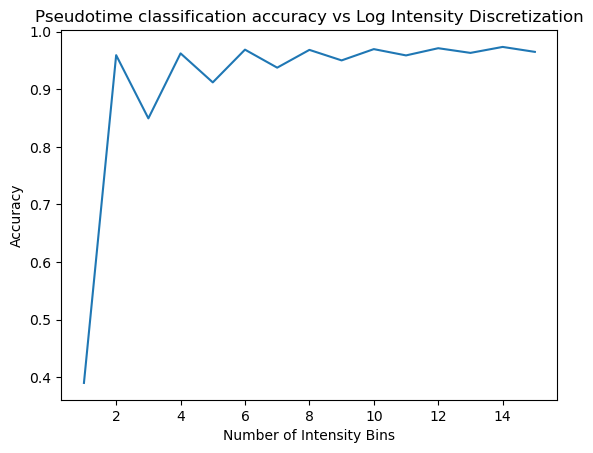

In [ ]:
# make classifier for log intensities to predict pseudotime bins using an MLE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

bin_count = 3
bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
# bins = np.asarray([0, 0.33, 0.67, 1+1e-5])
binned_fucci_time = np.digitize(comb_pseudotimes, bins) - 1

def ideal_model_perf(int_bin_count, time_labels):
    intensity_bins = np.linspace(comb_log_intensities.min(), comb_log_intensities.max() + 1e-5, int_bin_count + 1)
    binned_log_intensities = np.digitize(comb_log_intensities, intensity_bins) - 1

    X_train, X_test, y_train, y_test = train_test_split(binned_log_intensities, time_labels, test_size=0.5, random_state=42)

    # train classifier
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # get confusion matrix
    y_pred = clf.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    return score, conf, clf

scores = []
int_bins_range = list(range(1, 16))
for int_bin_count in int_bins_range:
    score, conf, clf = ideal_model_perf(int_bin_count, binned_fucci_time)
    scores.append(score)

plt.clf()
plt.plot(int_bins_range, scores)
plt.title("Pseudotime classification accuracy vs Log Intensity Discretization")
plt.xlabel("Number of Intensity Bins")
plt.ylabel("Accuracy")
plt.show()

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

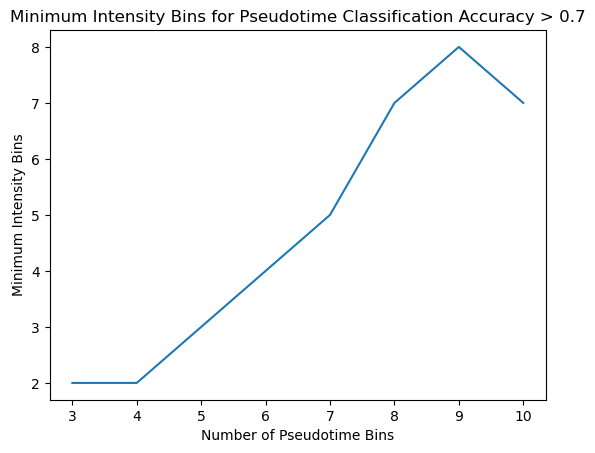

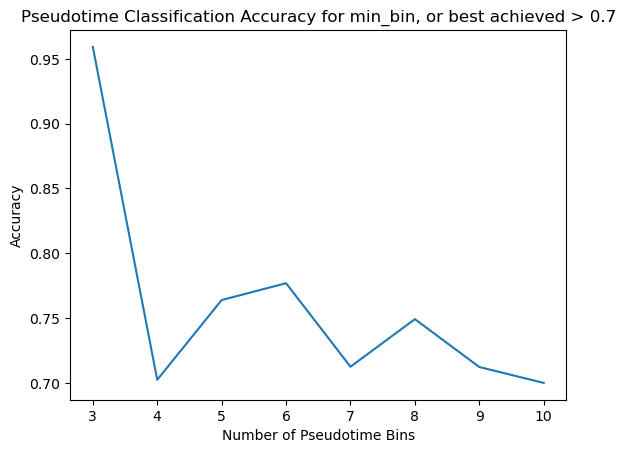

In [ ]:
score_min = 0.70
max_bins = 10
bin_counts = range(3, 11, 1)

scores = []
min_bins = []
for bin_count in bin_counts:
    bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
    binned_fucci_time = np.digitize(comb_pseudotimes, bins) - 1

    found = False
    for int_bin_count in range(1, max_bins + 1):
        score, conf, clf = ideal_model_perf(int_bin_count, binned_fucci_time)
        if score > score_min:
            found = True
            scores.append(score)
            min_bins.append(int_bin_count)
            break
    if not found:
        scores.append(score)
        min_bins.append(int_bin_count)


plt.clf()
plt.plot(list(bin_counts), min_bins)
plt.title(f"Minimum Intensity Bins for Pseudotime Classification Accuracy > {score_min}")
plt.xlabel("Number of Pseudotime Bins")
plt.ylabel("Minimum Intensity Bins")
plt.show()

plt.clf()
plt.plot(list(bin_counts), scores)
plt.title(f"Pseudotime Classification Accuracy for min_bin, or best achieved > {score_min}")
plt.xlabel("Number of Pseudotime Bins")
plt.ylabel("Accuracy")
plt.show()

# intensity dataset creation

In [ ]:
from utils import get_images_percentiles

In [ ]:
# go through each dataset and print the number of cells it contains per well
# the well is indicated by the parent folder in the sample_name column
for dataset in datasets:
    print(dataset)
    index_df = dataset_indices[dataset]
    wells = index_df["sample_name"].apply(lambda x: Path(x).stem)
    print(len(wells.unique()))

fucci_cham
94
fucci_tile
35
fucci_over
13
hpacc
30
ccnb1
1712


In [ ]:
# add the wells column to the index dataframe
for dataset in datasets:
    print(dataset)
    index_df = dataset_indices[dataset]
    wells = index_df["sample_name"].apply(lambda x: Path(x).stem)
    index_df["well"] = wells
    print(len(index_df["well"]))
    print(len(index_df))

fucci_cham
94
94
fucci_tile
35
35
fucci_over
13
13
hpacc
30
30
ccnb1
1712
1712


/tmp/ipykernel_2512052/3394232997.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_df["well"] = wells


In [ ]:
resolution = 6 # bit
buckets = 2 ** resolution
eval_percentiles = np.array(list(range(0, buckets, 1))) / (buckets - 1) * 100
eval_percentiles

array([  0.        ,   1.58730159,   3.17460317,   4.76190476,
         6.34920635,   7.93650794,   9.52380952,  11.11111111,
        12.6984127 ,  14.28571429,  15.87301587,  17.46031746,
        19.04761905,  20.63492063,  22.22222222,  23.80952381,
        25.3968254 ,  26.98412698,  28.57142857,  30.15873016,
        31.74603175,  33.33333333,  34.92063492,  36.50793651,
        38.0952381 ,  39.68253968,  41.26984127,  42.85714286,
        44.44444444,  46.03174603,  47.61904762,  49.20634921,
        50.79365079,  52.38095238,  53.96825397,  55.55555556,
        57.14285714,  58.73015873,  60.31746032,  61.9047619 ,
        63.49206349,  65.07936508,  66.66666667,  68.25396825,
        69.84126984,  71.42857143,  73.01587302,  74.6031746 ,
        76.19047619,  77.77777778,  79.36507937,  80.95238095,
        82.53968254,  84.12698413,  85.71428571,  87.3015873 ,
        88.88888889,  90.47619048,  92.06349206,  93.65079365,
        95.23809524,  96.82539683,  98.41269841, 100.  

In [ ]:
# now go through each of the wells in each dataset and load all the images from that well
# then calculate the intensity percentiles the well's images
# these need to be saved in the order of the samples in the original index dataframe
import utils
utils.silent = True
dataset_well_percentiles = {}
for dataset in datasets:
    index_df = dataset_indices[dataset]
    wells = index_df["well"]
    well_intensity_percentiles = {}
    for well in tqdm(wells.unique(), desc=dataset):
        well_df = index_df[wells == well]
        well_images = []
        for row in well_df.iterrows():
            well_images.append(torch.load(row[1][2]))
        well_images = torch.stack(well_images).numpy()
        values, percentiles = get_images_percentiles(well_images, percentiles=eval_percentiles, non_zero=True)
        # only want the reference channels' percentiles
        well_intensity_percentiles[well] = values[:2, :].flatten()
    dataset_well_percentiles[dataset] = well_intensity_percentiles

ccnb1: 100%|██████████| 1712/1712 [01:48<00:00, 15.76it/s]


In [ ]:
# need to get the wells for each sample in the dataset and save a copy of the intensity percentiles for each well in that order
for dataset in datasets:
    if dataset != "ccnb1":
        continue
    index_df = dataset_indices[dataset]
    wells = index_df["well"]
    well_percentiles = dataset_well_percentiles[dataset]
    dataset_intensity_percentiles = []
    for row in tqdm(index_df.iterrows(), desc=dataset, total=len(index_df)):
        well = row[1]["well"]
        num_cells = len(torch.load(row[1][2]))
        dataset_intensity_percentiles.append(np.tile(well_percentiles[well], (num_cells, 1)))
    print([percentile.shape for percentile in dataset_intensity_percentiles])
    dataset_intensity_percentiles = np.concatenate(dataset_intensity_percentiles, axis=0)
    print(dataset_intensity_percentiles.shape)
    np.save(data_dirs[dataset] / f"{dataset}_intensity_percentiles.npy", dataset_intensity_percentiles)

ccnb1: 100%|██████████| 1712/1712 [00:09<00:00, 172.56it/s]

[(20, 128), (11, 128), (17, 128), (14, 128), (19, 128), (9, 128), (9, 128), (8, 128), (8, 128), (29, 128), (21, 128), (10, 128), (31, 128), (33, 128), (13, 128), (11, 128), (19, 128), (28, 128), (13, 128), (21, 128), (16, 128), (10, 128), (9, 128), (14, 128), (15, 128), (52, 128), (14, 128), (13, 128), (9, 128), (9, 128), (10, 128), (32, 128), (5, 128), (10, 128), (15, 128), (5, 128), (13, 128), (12, 128), (14, 128), (40, 128), (7, 128), (13, 128), (18, 128), (11, 128), (17, 128), (15, 128), (9, 128), (28, 128), (9, 128), (32, 128), (27, 128), (20, 128), (15, 128), (9, 128), (7, 128), (14, 128), (9, 128), (35, 128), (12, 128), (9, 128), (14, 128), (14, 128), (20, 128), (13, 128), (16, 128), (13, 128), (6, 128), (14, 128), (9, 128), (13, 128), (13, 128), (23, 128), (20, 128), (23, 128), (15, 128), (21, 128), (25, 128), (16, 128), (11, 128), (25, 128), (19, 128), (14, 128), (19, 128), (21, 128), (12, 128), (13, 128), (15, 128), (14, 128), (30, 128), (4, 128), (16, 128), (15, 128), (14, 1

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 122 has size 64